In [1]:
import warnings
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
warnings.simplefilter('ignore', category=UserWarning)
warnings.filterwarnings('ignore',category=ImportWarning)
warnings.filterwarnings('ignore',category=DeprecationWarning)
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

import pandas as pd
import numpy as np
import time

import category_encoders as ce
from scipy.stats import randint
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import ADASYN
from BorutaShap import BorutaShap
from xgboost import XGBClassifier

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler # StandardScaler, MaxAbsScaler, RobustScaler
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, HalvingRandomSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.utils.fixes import loguniform
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
import operator


In [2]:
# Train test split parameters
test_holdout_percentage = 0.20

# Leave One Out Encoder Sigma value
sigma = 0.05

# Feature model parameters
feature_model_n_estimators = 200
feature_model_max_depth = 70
feature_model_max_features = 0.50

# BorutaShap parameters
feature_model_n_trials = 200

# ADASYN sampling multiplier
adasyn_class_multiplier = 1

# Specify model pipeline parameters
scoring = 'accuracy'
n_cross_validation = 5

# Specify the HalvingRandomSearchCV parameters
halving_parameter = 2.0
max_resource = 2000
resource_divisor = 2.0
min_resource = int(round((max_resource / resource_divisor), 0))


In [3]:
# Create timer to calculate total workbook time in hours
start_time = time.time()

## IMPORT PROCESSED NFL-DATA-PY CSV FILE
##### https://pypi.org/project/nfl-data-py/

In [4]:
# Import csv file from nfl-data-py
df = pd.read_csv(r'/Users/ttas2/Documents/Python/nfl-machine-learning-models/output_files/nfl_post_processing_run_pass_classification_data.csv')

df.shape

(59261, 168)

In [5]:
# Print columns with missing values
print(df.columns[df.isnull().any()].tolist())

[]


In [6]:
# Convert binary columns to integers
binary_columns = df.columns[df.isin([0,1]).all()].tolist()
df[binary_columns] = df[binary_columns].apply(pd.to_numeric, downcast='integer', errors='coerce', axis=1)

df.sample(2)

,week,posteam,posteam_type,defteam,yardline_100,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,game_half,qtr,...,remain_yds_div_def_dl_count,remain_yds_prod_def_dl_count,remain_yds_div_def_db_count,remain_yds_prod_def_db_count,remain_yds_div_score_diff,remain_yds_prod_score_diff,run_ratio_off_priors,run_ratio_def_priors,posteam_season,defteam_season
15541,16,DAL,home,PHI,61.0,348,348,2148,1,2,...,0.875,14.0,0.70,17.5,-1.166667,-10.5,0.310847,0.300000,dal_2022,phi_2022
35784,12,MIA,home,HOU,77.0,648,648,2448,1,2,...,1.250,20.0,1.25,20.0,0.294118,85.0,0.125000,0.522222,mia_2022,hou_2022


In [7]:
# Target frequency
target_count = df.play_type.value_counts(normalize=True)
target_count

play_type
pass    0.598539
run     0.401461
Name: proportion, dtype: float64

In [8]:
df['play_type'] = np.where(df['play_type'] == 'pass', 1, 0)

## TRAIN TEST SPLIT
##### https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [9]:
# split data into target and feature datasets
X, y = df.loc[:, df.columns != 'play_type'], df['play_type']

initial_features = X.columns.to_list()

# Create train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_holdout_percentage, random_state=67)

print(X_train.shape[1], 'initial features before processing')

167 initial features before processing


## BASELINE MODEL
##### https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html

In [10]:
# Create and fit baseline model to compare performance
baseline_model = DummyClassifier(strategy='most_frequent', random_state=67)
baseline_model.fit(X_train, y_train)

# Calculate model accuracy on test data
y_baseline_pred = baseline_model.predict(X_test)

print(f"Baseline accuracy: {round(accuracy_score(y_test,y_baseline_pred)*100, 1)}%")
print(f"Baseline f1 score: {round(f1_score(y_test,y_baseline_pred)*100, 1)}%")


Baseline accuracy: 60.2%
Baseline f1 score: 75.2%


## ENCODE CATEGORICAL FEATURES
##### https://contrib.scikit-learn.org/category_encoders/leaveoneout.html

In [11]:
# Encoded column represents mean response over all rows for this category, providing one-column representation while avoiding direct response leakage

pre_features = X_train.columns.to_list()
categorical_features = list(X_train.select_dtypes(include='object'))

# Sigma adds normal (Gaussian) distribution noise into training data in order to decrease over-fitting (testing data are untouched). Sigma gives the standard deviation (spread or “width”) of the normal distribution. The optimal value is commonly between 0.05 and 0.6. The default is to not add noise, but that leads to significantly suboptimal results.
encoder = ce.LeaveOneOutEncoder(return_df=True, cols=categorical_features, handle_missing='value', handle_unknown='value', sigma=sigma, random_state=67, drop_invariant=False)

X_train = encoder.fit_transform(X_train, y_train)
X_test = encoder.transform(X_test)

post_features = X_train.columns.to_list()

# Compare 2 lists and identify elements in first list not in second list
def diff(list1, list2):
    return list(set(list1) - set(list2))

print('Total observations in training dataset:', len(X_train))
print('Total features before encoding:', len(pre_features))
print(' ')
print('Categorical features dropped due to invariance:', diff(pre_features, post_features))
print(' ')
print('Total features after categorical encoding:', len(post_features))
print('Column names:', X_train.columns.to_list())

Total observations in training dataset: 47408
Total features before encoding: 167
 
Categorical features dropped due to invariance: []
 
Total features after categorical encoding: 167
Column names: ['week', 'posteam', 'posteam_type', 'defteam', 'yardline_100', 'quarter_seconds_remaining', 'half_seconds_remaining', 'game_seconds_remaining', 'game_half', 'qtr', 'down', 'goal_to_go', 'ydstogo', 'shotgun', 'no_huddle', 'posteam_timeouts_remaining', 'defteam_timeouts_remaining', 'posteam_score', 'defteam_score', 'score_differential', 'no_score_prob', 'fg_prob', 'safety_prob', 'td_prob', 'ep', 'wp', 'drive_play_count', 'spread_line', 'total_line', 'div_game', 'roof', 'surface', 'possession_team', 'offense_formation', 'offense_personnel', 'defenders_in_box', 'defense_personnel', 'n_offense', 'n_defense', 'qb_rank', 'qb_pts', 'qb_plays', 'qb_qbr_raw', 'qb_qbr', 'qb_pass', 'qb_run', 'report_eligible', 'off_rb_count', 'off_te_count', 'off_wr_count', 'off_hb_count', 'off_ol_count', 'def_dl_count'

## FEATURE SELECTION
##### https://pypi.org/project/BorutaShap/

In [12]:
feature_model = RandomForestClassifier(ccp_alpha=1e-03,                             # cost-complexity pruning is an algorithm used to prune a tree to avoid over-fitting
                                      criterion='gini',
                                      max_depth=feature_model_max_depth, 
                                      max_features=feature_model_max_features,
                                      max_leaf_nodes=50,                           # max_leaf_nodes is not supported for bootstrap=False
                                      max_samples=0.30,                            # max_samples is not supported for bootstrap=False
                                      min_impurity_decrease=1e-05,                 # A node will be split if this split induces a decrease of the impurity greater than or equal to this value
                                      #min_samples_leaf=0.02,
                                      #min_samples_split=0.02,
                                      #min_weight_fraction_leaf=0.03,
                                      n_estimators=feature_model_n_estimators,
                                      class_weight='balanced_subsample',
                                      bootstrap=True,
                                      oob_score=False,                              # Only for bootstrap=True
                                      warm_start=False,
                                      n_jobs=6,
                                      random_state=67,
                                       )

In [13]:
# no model selected default is Random Forest
Feature_Selector = BorutaShap(importance_measure='shap',
                              classification=True,
                              model=feature_model,
                              )

Feature_Selector.fit(X=X_train,
                    y=y_train,
                    n_trials=feature_model_n_trials,
                    sample=False,
                    random_state=67,
                    )

100%|██████████| 200/200 [2:18:21<00:00, 41.51s/it]  

55 attributes confirmed important: ['offense_personnel', 'prev1_yards_gained', 'posteam_season', 'drive_incomplete_pass_pcnt', 'half_seconds_div_score_diff', 'half_seconds_remaining', 'posteam', 'prev2_wpa', 'defense_personnel', 'prev1_incomplete_pass', 'run_ratio_def_priors', 'no_score_prob', 'remain_yds_prod_def_dl_count', 'two_min_warning', 'prev1_play_run_outside', 'defenders_in_box', 'shotgun', 'posteam_score', 'remain_yds_div_off_hb_count', 'prev1_wpa', 'remaining_yards_per_down', 'safety_prob', 'remain_yds_div_def_db_count', 'prev1_play_pass_deep', 'play_type_prev3', 'td_prob', 'defteam_score', 'remain_yds_prod_def_db_count', 'possession_team', 'score_differential', 'def_db_count', 'play_type_prev2', 'remain_yds_div_def_box', 'ep', 'qtr', 'remain_yds_prod_off_hb_count', 'remain_yds_div_def_dl_count', 'remain_yds_prod_def_box', 'posteam_timeouts_remaining', 'game_seconds_remaining', 'down', 'wp', 'yardline_100', 'remain_yds_prod_score_diff', 'ydstogo', 'run_ratio_off_priors', 're

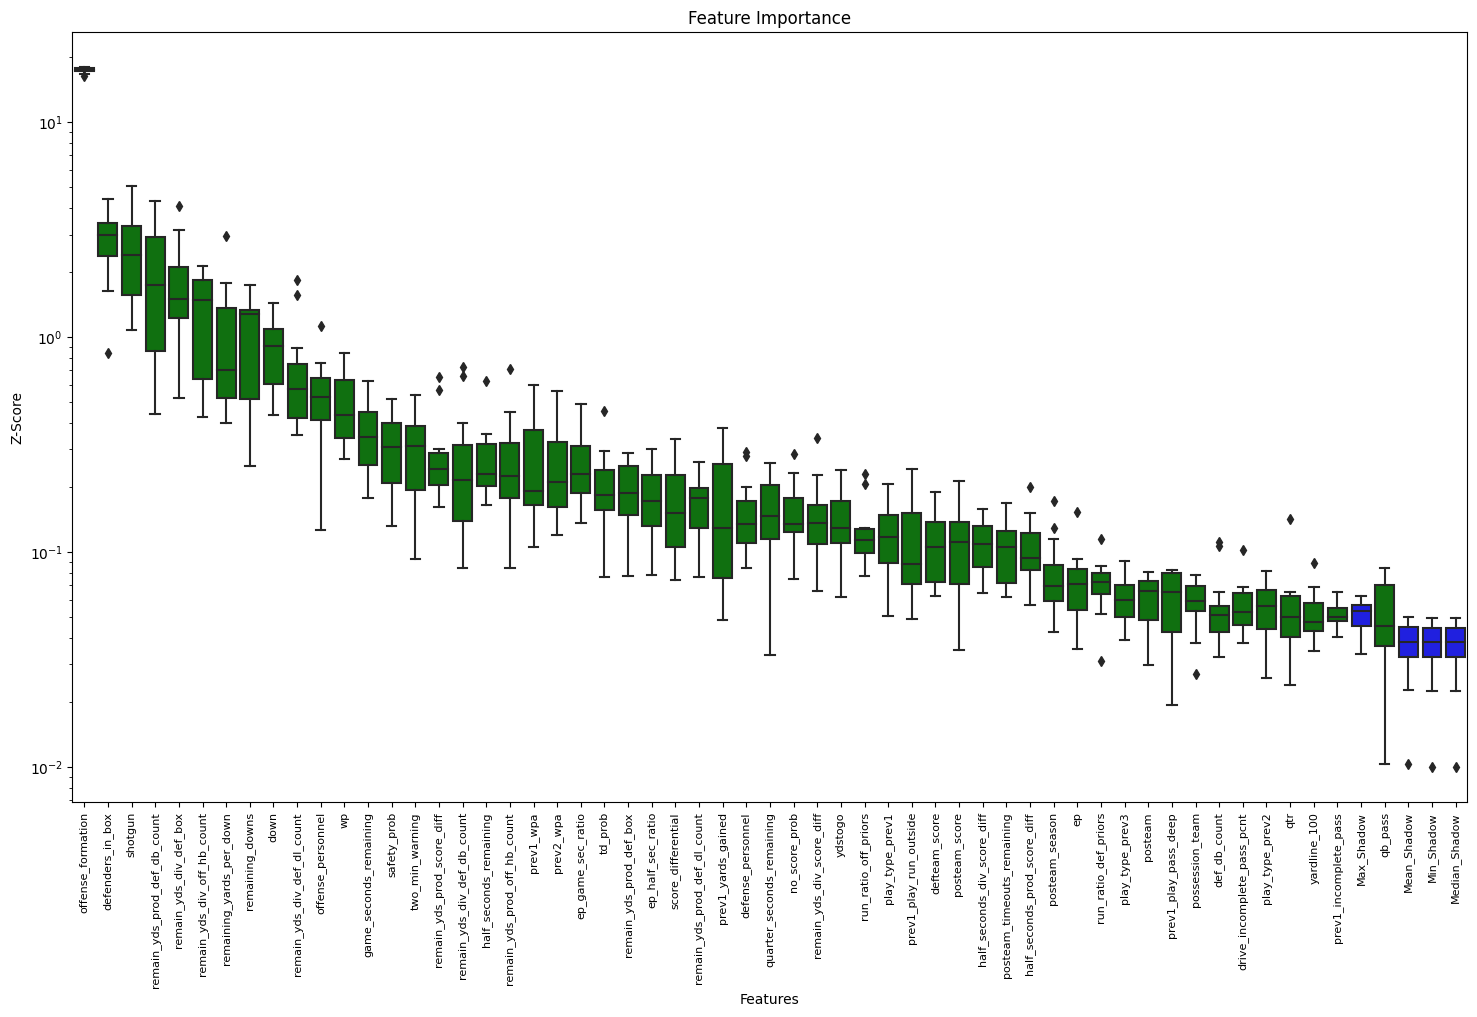

In [14]:
# Plot selected features with shap values on x-axis
Feature_Selector.plot(which_features='accepted', figsize=(18, 10), y_scale='log')

In [15]:
# Drops features that were identified by BorutaShap as not important
features_to_remove = Feature_Selector.features_to_remove

X_train = X_train.drop(columns=features_to_remove)
X_test = X_test.drop(columns=features_to_remove)

print('Training features:', X_train.shape[1])
print('Testing features:', X_test.shape[1])
print('Most important features:', X_train.columns.to_list())

Training features: 55
Testing features: 55
Most important features: ['posteam', 'yardline_100', 'quarter_seconds_remaining', 'half_seconds_remaining', 'game_seconds_remaining', 'qtr', 'down', 'ydstogo', 'shotgun', 'posteam_timeouts_remaining', 'posteam_score', 'defteam_score', 'score_differential', 'no_score_prob', 'safety_prob', 'td_prob', 'ep', 'wp', 'possession_team', 'offense_formation', 'offense_personnel', 'defenders_in_box', 'defense_personnel', 'qb_pass', 'def_db_count', 'play_type_prev1', 'play_type_prev2', 'play_type_prev3', 'prev1_play_run_outside', 'prev1_play_pass_deep', 'prev1_incomplete_pass', 'drive_incomplete_pass_pcnt', 'prev1_yards_gained', 'prev1_wpa', 'prev2_wpa', 'remaining_downs', 'remaining_yards_per_down', 'two_min_warning', 'ep_half_sec_ratio', 'ep_game_sec_ratio', 'half_seconds_div_score_diff', 'half_seconds_prod_score_diff', 'remain_yds_div_def_box', 'remain_yds_prod_def_box', 'remain_yds_div_off_hb_count', 'remain_yds_prod_off_hb_count', 'remain_yds_div_def

In [16]:
# Calculate workbook processing time in hours
end_time = time.time()
total_time = end_time - start_time

print('Total time:', round(total_time / 3600, 2), 'hours')

Total time: 2.31 hours


## MODEL PIPELINE
##### https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html
##### https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html
##### https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html
##### https://www.statsmodels.org/dev/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html
##### https://imbalanced-learn.org/stable/references/over_sampling.html
##### https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingRandomSearchCV.html
##### https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
##### https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
##### https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
##### https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html
##### https://xgboost.readthedocs.io/en/stable/parameter.html

In [17]:
# Create feature type lists for column transform stage of the pipeline
ordinal_features = X_train.columns[X_train.isin([1,2,3,4,5]).all()].tolist()
categorical_features = list(X_train.select_dtypes(include='object'))
boolean_features = X_train.columns[X_train.isin([0, 1]).all()].tolist()

numeric_features = [x for x in X_train.columns if x not in ordinal_features]
numeric_features = [x for x in numeric_features if x not in categorical_features]
numeric_features = [x for x in numeric_features if x not in boolean_features]

#print('categorical features:', len(categorical_features), ':', categorical_features)
print('ordinal features:', len(ordinal_features), ':', ordinal_features)
print('boolean features:', len(boolean_features), ':', boolean_features)
print('numeric features:', len(numeric_features), ':', numeric_features)

ordinal features: 3 : ['qtr', 'down', 'remaining_downs']
boolean features: 5 : ['shotgun', 'prev1_play_run_outside', 'prev1_play_pass_deep', 'prev1_incomplete_pass', 'two_min_warning']
numeric features: 47 : ['posteam', 'yardline_100', 'quarter_seconds_remaining', 'half_seconds_remaining', 'game_seconds_remaining', 'ydstogo', 'posteam_timeouts_remaining', 'posteam_score', 'defteam_score', 'score_differential', 'no_score_prob', 'safety_prob', 'td_prob', 'ep', 'wp', 'possession_team', 'offense_formation', 'offense_personnel', 'defenders_in_box', 'defense_personnel', 'qb_pass', 'def_db_count', 'play_type_prev1', 'play_type_prev2', 'play_type_prev3', 'drive_incomplete_pass_pcnt', 'prev1_yards_gained', 'prev1_wpa', 'prev2_wpa', 'remaining_yards_per_down', 'ep_half_sec_ratio', 'ep_game_sec_ratio', 'half_seconds_div_score_diff', 'half_seconds_prod_score_diff', 'remain_yds_div_def_box', 'remain_yds_prod_def_box', 'remain_yds_div_off_hb_count', 'remain_yds_prod_off_hb_count', 'remain_yds_div_de

In [18]:
# Outlier removal
def iqr_outliers(x, features):

    out_index_list = []
        
    for col in features:
        q1 = np.nanpercentile(x[col], 25.)
        q3 = np.nanpercentile(x[col], 75.)
        
        cut_off = (q3 - q1) * 1.5
        upper, lower = q3 + cut_off, q1 - cut_off
                
        outliers_index = x[col][(x[col] < lower) | (x[col] > upper)].index.tolist()
        out_index_list.extend(outliers_index)
        
    # Remove duplicates
    list(set(out_index_list)).sort()

In [19]:
# Specify the transformations per data type
num_trans = Pipeline(steps=[('simple_imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
                            ('iqr_outlier', iqr_outliers(X_train, numeric_features)),
                            ('scaler', MinMaxScaler()),
                           ])

cat_trans = Pipeline(steps=[('simple_imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                            ('onehot_encoder', OneHotEncoder(sparse=False, handle_unknown='infrequent_if_exist')),
                            ])

ord_trans = Pipeline(steps=[('simple_imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                            ('ordinal_encoder', OrdinalEncoder(categories='auto', handle_unknown='error')),
                            ('scaler', MinMaxScaler()),
                           ])
                             
Column_Transform = ColumnTransformer(transformers=[('numeric_transform', num_trans, numeric_features),
                                                   ('categorical_transform', cat_trans, categorical_features),
                                                   ('ordinal_transform', ord_trans, ordinal_features),
                                                   ],
                                     remainder='passthrough',
                                    )

In [20]:
# Specify number of target classes
n_classes = y_train.nunique() * adasyn_class_multiplier

In [21]:
def random_search():
    
    pipeline1 = Pipeline([
    ('col', Column_Transform),
    ('smpl', ADASYN(n_neighbors=n_classes, sampling_strategy='not majority', random_state=67)),
    ('clf', RandomForestClassifier()),
    ])
    
    pipeline2 = Pipeline([
    ('col', Column_Transform),
    ('smpl', ADASYN(n_neighbors=n_classes, sampling_strategy='not majority', random_state=67)),
    ('clf', ExtraTreesClassifier()),
    ])
    
    pipeline3 = Pipeline([
    ('col', Column_Transform),
    ('smpl', ADASYN(n_neighbors=n_classes, sampling_strategy='not majority', random_state=67)),
    ('clf', GradientBoostingClassifier()),
    ])
    
    pipeline4 = Pipeline([
    ('col', Column_Transform),
    ('smpl', ADASYN(n_neighbors=n_classes, sampling_strategy='not majority', random_state=67)),
    ('clf', AdaBoostClassifier()),
    ])

    # RandomForestClassifier
    parameters1 = {
    'clf__bootstrap': [False],
    'clf__ccp_alpha': loguniform(1e-07, 1e-01),              # cost-complexity pruning is an algorithm used to prune a tree to avoid over-fitting
    'clf__criterion': ['gini','entropy'],
    'clf__max_depth': randint(10, 40),
    'clf__max_features': loguniform(0.02, 0.40), 
    'clf__min_impurity_decrease': loguniform(1e-08, 1e-04),
    #'clf__max_samples': loguniform(0.02, 0.49),              # max_samples is not supported for bootstrap=False
    'clf__min_samples_leaf': loguniform(0.01, 0.20),
    'clf__min_samples_split': loguniform(0.01, 0.20),
    'clf__min_weight_fraction_leaf': loguniform(0.01, 0.20),
    'clf__oob_score': [False],                                # Only for bootstrap=True
    'clf__warm_start': [True, False],
    'clf__n_jobs': [6],
    'clf__random_state': [67],
    }

    # ExtraTreesClassifier
    parameters2 = {
    'clf__bootstrap': [False],
    'clf__ccp_alpha': loguniform(1e-06, 1e-01),               # cost-complexity pruning is an algorithm used to prune a tree to avoid over-fitting
    'clf__criterion': ['gini','entropy'],
    'clf__max_depth': randint(10, 60),
    'clf__max_features': loguniform(0.35, 0.85),
    'clf__max_leaf_nodes': randint(20, 60),
    #'clf__max_samples': loguniform(0.10, 0.50),               # max_samples is not supported for bootstrap=False
    'clf__min_impurity_decrease': loguniform(1e-06, 1e-01),
    'clf__min_samples_leaf': loguniform(0.02, 0.30),
    'clf__min_samples_split': loguniform(0.01, 0.30),
    'clf__min_weight_fraction_leaf': loguniform(0.02, 0.30),
    'clf__oob_score': [False],                                # Only for bootstrap=True
    'clf__warm_start': [True, False],
    'clf__n_jobs': [6],
    'clf__random_state': [67],
    }

    # GradientBoostingClassifier
    parameters3 = {
    'clf__criterion': ['friedman_mse'],
    'clf__ccp_alpha': loguniform(1e-06, 1e-02),                # cost-complexity pruning is an algorithm used to prune a tree to avoid over-fitting
    'clf__learning_rate': loguniform(1e-05, 1e-00),
    'clf__loss': ['log_loss','exponential'],
    'clf__max_depth': randint(10, 40),
    'clf__max_features': loguniform(0.20, 0.75), 
    'clf__max_leaf_nodes': randint(15, 60),
    'clf__min_weight_fraction_leaf': loguniform(0.25, 0.70),   # New in version 0.24.
    'clf__min_impurity_decrease': loguniform(1e-08, 1e-04),
    'clf__min_samples_leaf': loguniform(0.02, 0.35),
    'clf__min_samples_split': loguniform(0.02, 0.35),
    'clf__n_iter_no_change': [150],
    'clf__tol': loguniform(1e-08, 1e-04),
    'clf__validation_fraction': loguniform(0.10, 0.15),
    'clf__warm_start': [True],
    'clf__subsample': loguniform(0.90, 1.00),                  # Choosing subsample < 1.0 leads to a reduction of variance and an increase in bias
    'clf__random_state': [67],
    }

    # AdaBoostClassifier
    parameters4  = {
    'clf__algorithm': ['SAMME','SAMME.R'],
    'clf__learning_rate':  loguniform(1e-10, 1e-01),
    'clf__random_state': [67],
    }

    pars = [parameters1, parameters2, parameters3, parameters4]
    pips = [pipeline1, pipeline2, pipeline3, pipeline4]

    result = []
    
    for i in range(len(pars)):
        
        rs = HalvingRandomSearchCV(pips[i],
                                   pars[i],
                                   factor=halving_parameter,
                                   resource='clf__n_estimators',
                                   n_candidates='exhaust',
                                   min_resources=min_resource,
                                   max_resources=max_resource,
                                   scoring=scoring,
                                   aggressive_elimination=False,
                                   return_train_score=True,
                                   refit=True,                   
                                   cv=n_cross_validation,
                                   n_jobs=6,
                                   verbose=1,
                                   random_state=67,
                                   error_score='raise',
                                  )

        # Fit models on training data
        rs = rs.fit(X_train, y_train)
        
        # Apply models to test data to determine model performance
        y_pred = rs.predict(X_test)
        y_pred_prob = rs.predict_proba(X_test)[:, 1]

        print(" ")
        print(" ")
        
        # storing model results
        result.append({
        'grid': rs,
        'cv results': rs.cv_results_,
        'train accuracy score': rs.best_score_,
        'best params': rs.best_params_, 
        'best estimator': rs.best_estimator_,
        'feature importance': rs.best_estimator_.named_steps['clf'].feature_importances_,
        'test f1 score': f1_score(y_test, y_pred, average='micro'),
        'test accuracy score': accuracy_score(y_test, y_pred),
        'test balanced accuracy score': balanced_accuracy_score(y_test, y_pred),
        'test roc auc score': roc_auc_score(y_test, y_pred_prob),
        'test classification report': classification_report(y_test, y_pred, target_names=['pass','run'], digits=5),
        'test confusion matrix': confusion_matrix(y_test, y_pred),
        'cv': rs.cv,
        'model #': i + 1
        })

    # sorting results by best test score
    result = sorted(result, key=operator.itemgetter('test f1 score'), reverse=True)
    
    print(' ')
    for element in result:
        if element['model #']==1:
            print('Random Forest classifier: ')
        elif element['model #']==2:
            print('ExtraTrees classifier: ')
        elif element['model #']==3:
            print('GradientBoosting classifier: ')
        elif element['model #']==4:
            print('AdaBoost classifier: ')
        else:
            print('Other: ')  
        
        print('Parameters:  ' + str(element['best params']))
        print(' ')
        print('Train accuracy score:         ' + str(element['train accuracy score']))
        print('Test accuracy score:          ' + str(element['test accuracy score']))
        print('Test balanced accuracy score: ' + str(element['test accuracy score']))
        print('Test f1 score:                ' + str(element['test f1 score']))
        print('Test roc auc score:           ' + str(element['test roc auc score']))
        print(' ')
        print(element['test classification report'])
        print(element['test confusion matrix'])
        print(' ')
        print('-----------------------')
        print(' ')
        
        # Export best model as csv file
        pd.DataFrame(element['cv results']).to_csv(r'/Users/ttas2/Documents/Python/nfl-machine-learning-models/output_files/run_pass_classifier_model.csv')
        pd.DataFrame(element['feature importance'], index=X_train.columns).to_csv(r'/Users/ttas2/Documents/Python/nfl-machine-learning-models/output_files/run_pass_classifier_feature_importance.csv')


In [22]:
%%capture --no-stdout --no-display
random_search()

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 1000
max_resources_: 2000
aggressive_elimination: False
factor: 2.0
----------
iter: 0
n_candidates: 2
n_resources: 1000
Fitting 5 folds for each of 2 candidates, totalling 10 fits
----------
iter: 1
n_candidates: 1
n_resources: 2000
Fitting 5 folds for each of 1 candidates, totalling 5 fits
 
 
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 1000
max_resources_: 2000
aggressive_elimination: False
factor: 2.0
----------
iter: 0
n_candidates: 2
n_resources: 1000
Fitting 5 folds for each of 2 candidates, totalling 10 fits
----------
iter: 1
n_candidates: 1
n_resources: 2000
Fitting 5 folds for each of 1 candidates, totalling 5 fits
 
 
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 1000
max_resources_: 2000
aggressive_elimination: False
factor: 2.0
----------
iter: 0
n_candidates: 2
n_resources: 1000
Fitting 5 folds for each of 2 candidate

In [23]:
# Calculate workbook processing time in hours
end_time = time.time()
total_time = end_time - start_time

print('Total process time:', round(total_time / 3600, 2), 'hours')

Total process time: 3.18 hours


## LIST RESULTS